In [6]:
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector
from enum import Enum

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

def count(model, state):
    """Counts the number of citizens with the user-defined state"""
    count = 0
    for agent in model.schedule.agents:
        if agent.Health == state:
                count += 1
    return count

class Health(Enum):
    HEALTHY = 1 
    BURNING = 2 
    DEAD = 3

class Forest(Model):
    def __init__(self, height, width, density, seed=None):
        super().__init__(seed=seed)

        
        # setup Tree class attributes
        
        
        # setup data collection
        model_reporters = {'healthy': lambda m: count(m, Health.HEALTHY),
                           'burning': lambda m: count(m, Health.BURNING),
                           'dead': lambda m: count(m, Health.DEAD)}
       
        self.datacollector = DataCollector(model_reporters=model_reporters)
        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(width, height, torus=False)

        # Set up agents
        id = 1
        
        for i, x, y in self.grid.coord_iter():
            if self.random.random() < density:
                agent = Tree(id, self)
                if x == 0:
                    agent.Health = Health.BURNING
                self.grid.position_agent(agent, x, y)
                self.schedule.add(agent)
                id += 1
          
        
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
        
    
        
    def count_trees(self, model, agent_health):
        count = 0
        for agent in model.schedule.agents:
            if agent.Health == agent_health:
                count += 1
        return count
    
class Tree(Agent):
    def __init__(self, pos, model):
        super().__init__(pos, model)
        self.Health = Health.HEALTHY
        self.pos = pos
        
        
    def step(self):
        
        if self.Health == Health.BURNING:
            for neighbor in self.model.grid.iter_neighbors(self.pos, moore=False):
                if neighbor.Health == Health.HEALTHY:
                    neighbor.Health = Health.BURNING
                
            self.Health = Health.DEAD
        
   
        

In [7]:
import mesa

COLORS = {"HEALTHY": "#00AA00", "BURNING": "#880000", "DEAD": "#000000"}


def forest_fire_portrayal(tree):
    if tree is None:
        return
    portrayal = {"Shape": "rect", "w": 1, "h": 1, "Filled": "true", "Layer": 0}
    (x, y) = tree.pos
    portrayal["x"] = x
    portrayal["y"] = y
    portrayal["Color"] = COLORS[tree.Health]
    return portrayal


canvas_element = mesa.visualization.CanvasGrid(
    forest_fire_portrayal, 100, 100, 500, 500
)
tree_chart = mesa.visualization.ChartModule(
    [{"Label": label, "Color": color} for (label, color) in COLORS.items()]
)
pie_chart = mesa.visualization.PieChartModule(
    [{"Label": label, "Color": color} for (label, color) in COLORS.items()]
)

model_params = {
    "height": 100,
    "width": 100,
    "density": mesa.visualization.Slider("Tree density", 0.65, 0.01, 1.0, 0.01),
}
server = mesa.visualization.ModularServer(
    Forest, [canvas_element, tree_chart, pie_chart], "Forest Fire", model_params
)


<AxesSubplot:>

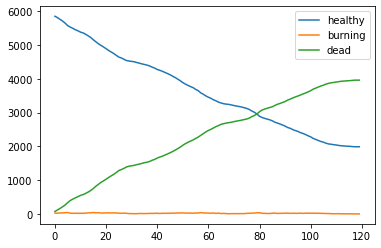

In [13]:
fire = Forest(100, 100, 0.6)
for i in range(120):
    fire.step()
results = fire.datacollector.get_model_vars_dataframe()
results.plot()